# IGRINS A0V whole bandwidth demo

From the May 17th Near-IR Innovation day at Texas Innovation Center!

Kyle, Gully, and Greg Mace

In [1]:
%config Completer.use_jedi = False

In [2]:
import torch
from blase.emulator import SparseLogEmulator, ExtrinsicModel, InstrumentalModel
import matplotlib.pyplot as plt
from gollum.phoenix import PHOENIXSpectrum
from gollum.telluric import TelFitSpectrum
from blase.utils import doppler_grid
import astropy.units as u
import numpy as np

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
%matplotlib inline
%config InlineBackend.figure_format='retina'

Woohoo! You have a version 1.11.0+cu102 of PyTorch


In [3]:
device

'cuda'

## Pre-process the data
We will quickly pre-process the HPF spectrum with the [muler](https://muler.readthedocs.io/en/latest/) library

In [4]:
from muler.hpf import HPFSpectrum, HPFSpectrumList

In [5]:
fn = '../../data/HPF/demo/Goldilocks_20220623T033933_v1.0_0001.spectra.fits'

In [6]:
raw_data = HPFSpectrumList.read(file=fn)

We run out of GPU RAM if we attempt to fit the entire HPF bandwidth!  Let's try a subset...

In [7]:
#raw_data = HPFSpectrumList([order for order in raw_data][0:10])

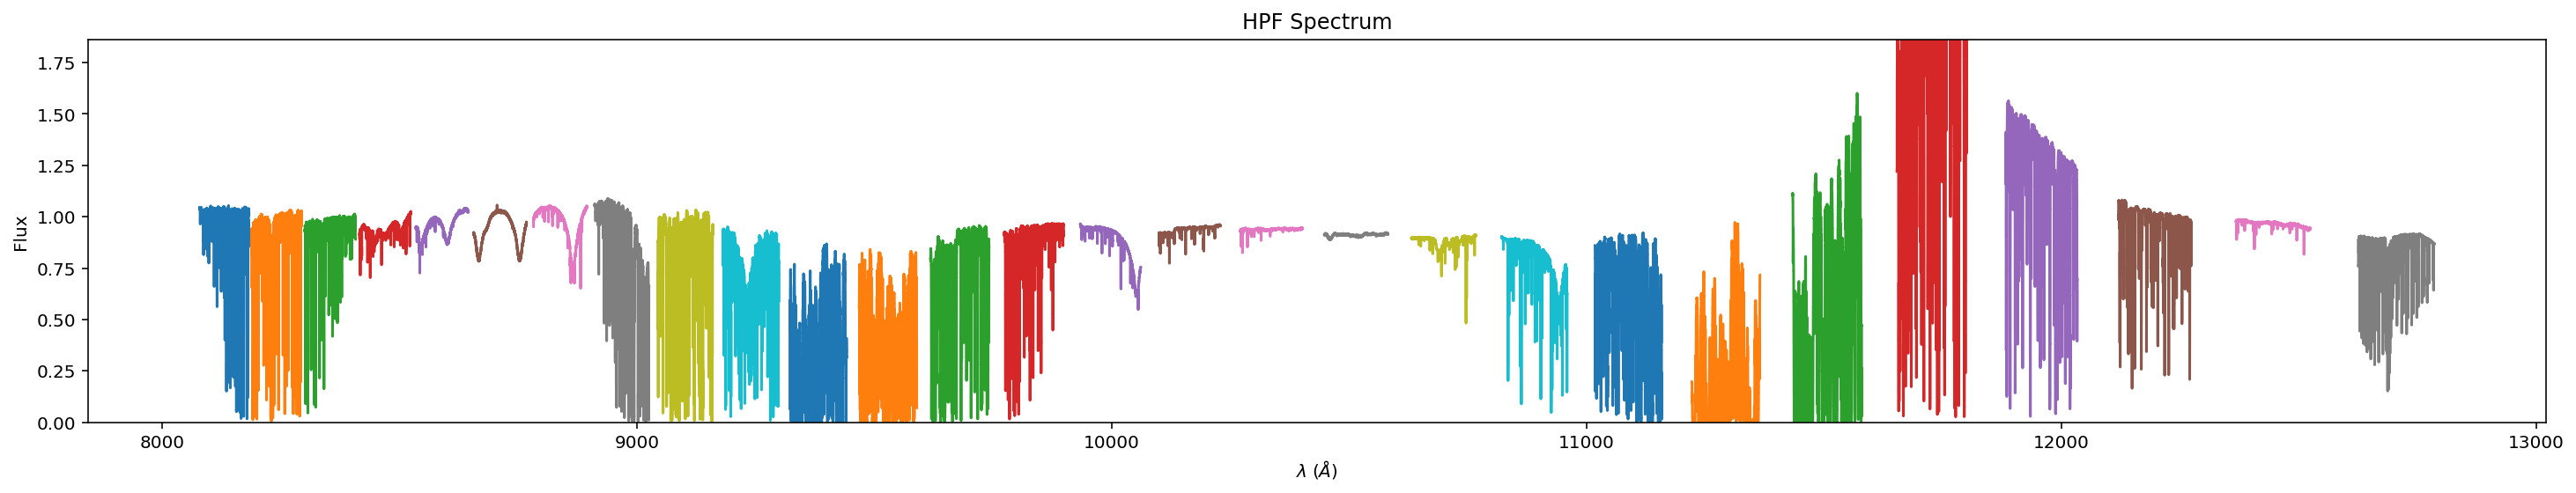

In [10]:
data = raw_data.flatten_by_black_body(9_400).sky_subtract().trim_edges((10, 2048)).remove_nans().deblaze().normalize()
ax = data.plot()

In [11]:
data = raw_data.flatten_by_black_body(9_400).sky_subtract().trim_edges((10, 2048)).remove_nans().deblaze().normalize(0).stitch()

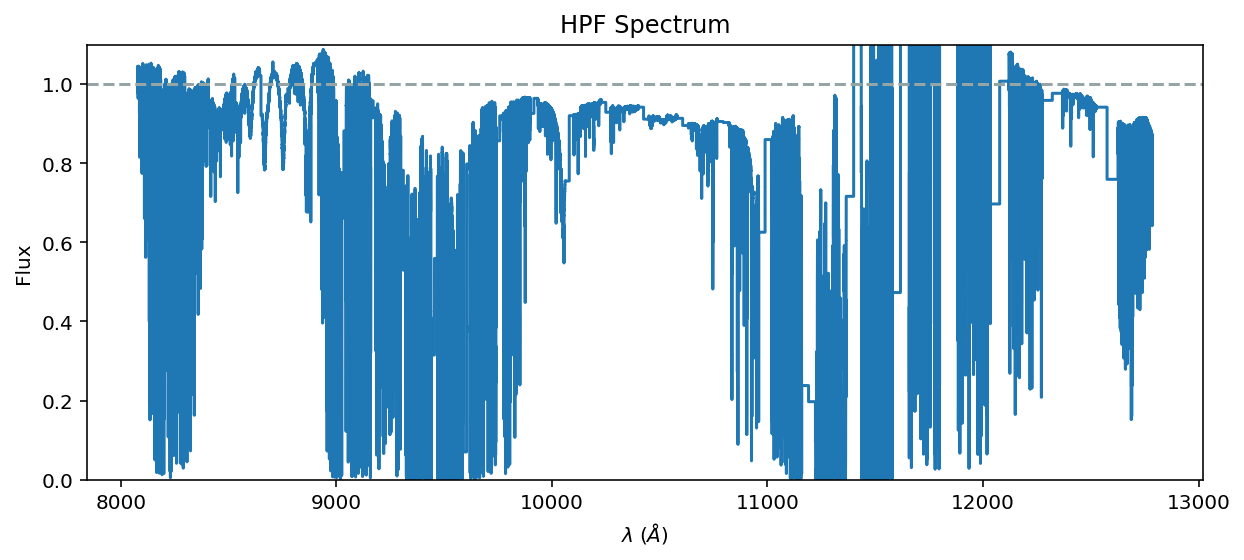

In [12]:
ax = data.plot(yhi=1.1);
ax.axhline(1.0, color='#95a5a6', linestyle='dashed');

In [13]:
wl_lo = data.wavelength.min().value-200.0
wl_hi = data.wavelength.max().value+200.0
wavelength_grid = doppler_grid(wl_lo, wl_hi)

### Retrieve the Phoenix model

A0V's have $T_{\mathrm{eff}}=9,400\;K$ and $\log{g}=4.0$

In [14]:
vsini_init = 118.80
RV_init = 41.9
teff_init=9_400
logg_init=4.0

<Spectrum1D(flux=<Quantity [0.56711024, 0.56715978, 0.56721875, ..., 0.57456667, 0.57456562,
           0.57456617]>, spectral_axis=<SpectralAxis 
   (observer to target:
      radial_velocity=0.0 km / s
      redshift=0.0)
  [ 7879.65,  7879.66,  7879.67, ..., 12985.4 , 12985.42, 12985.44] Angstrom>)>

In [18]:
spectrum = PHOENIXSpectrum(teff=teff_init, logg=logg_init, wl_lo=wl_lo, wl_hi=wl_hi)
spectrum = spectrum.divide_by_blackbody(teff_init)
spectrum = spectrum.normalize(percentile=98)
continuum_fit = spectrum.fit_continuum(polyorder=7)
flat_spectrum = spectrum.divide(continuum_fit, handle_meta="ff")

Make a flattened version of the clone.

<AxesSubplot:xlabel='$\\lambda \\;(\\AA)$', ylabel='Flux'>

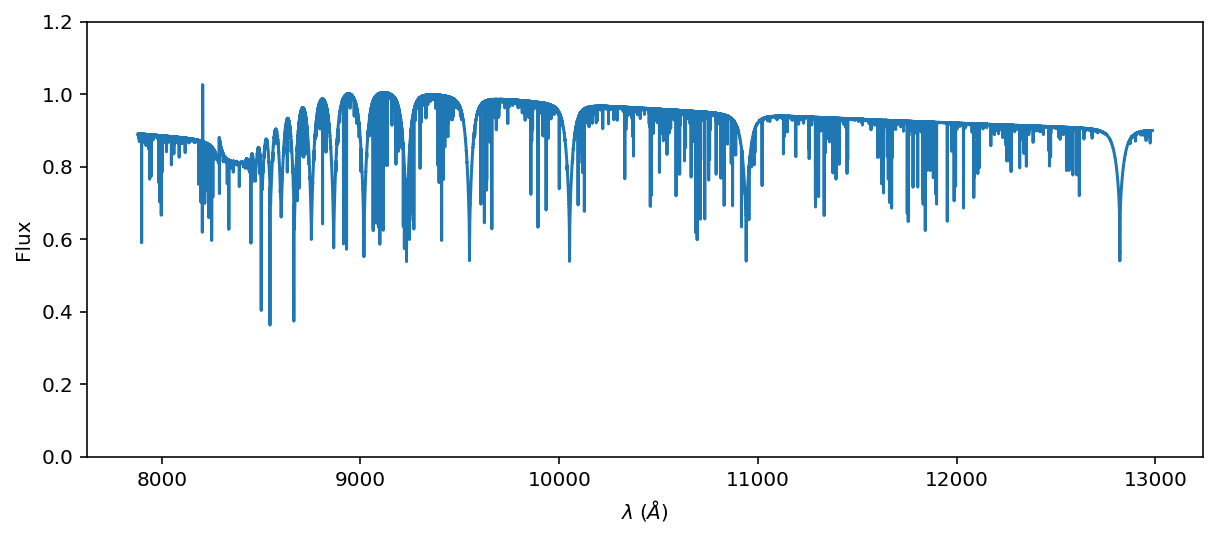

In [21]:
spectrum.plot(ylo=0)

### Special Hydrogen lines layer

The hydrogen lines are so deep and broad that they break our continuum finding system.  Let's build a special layer to fix that.

In [22]:
import astropy.constants as const

In [23]:
const.Ryd

<<class 'astropy.constants.codata2018.CODATA2018'> name='Rydberg constant' value=10973731.56816 uncertainty=2.1e-05 unit='1 / m' reference='CODATA 2018'>

In [24]:
def get_H_line_locations(n1=None, n2=None, wl_lo=None, wl_hi=None):
    '''Get the location of Hydrogen lines based on atomic energy levels'''
    n1 = np.array(n1)[:, np.newaxis]
    n2 = np.array(n2)
    lam_out = 1.0/(const.Ryd*(1/(n1**2) - 1/(n2**2) ))
    lam_out = np.unique(np.sort(np.abs(lam_out.reshape(-1).to(u.Angstrom)))).value
    if (wl_lo is not None) & (wl_hi is not None):
        mask = (lam_out > wl_lo) & (lam_out < wl_hi)
        lam_out = lam_out[mask]
    return lam_out

In [25]:
h_lines = get_H_line_locations(n1=range(3,4), 
                               n2=range(4, 20), wl_lo=wl_lo, wl_hi=wl_hi) 
h_lines = h_lines * 1.0005 # fudge_factor for vacuum/air

In [26]:
h_lines

array([ 8415.30397916,  8439.94713288,  8469.25250487,  8504.4901384 ,
        8547.40016351,  8600.42146934,  8667.0637658 ,  8752.53776743,
        8864.87502673,  9017.03753513,  9231.19217659,  9548.22301902,
       10051.74259229, 10940.67220929, 12821.10024526])

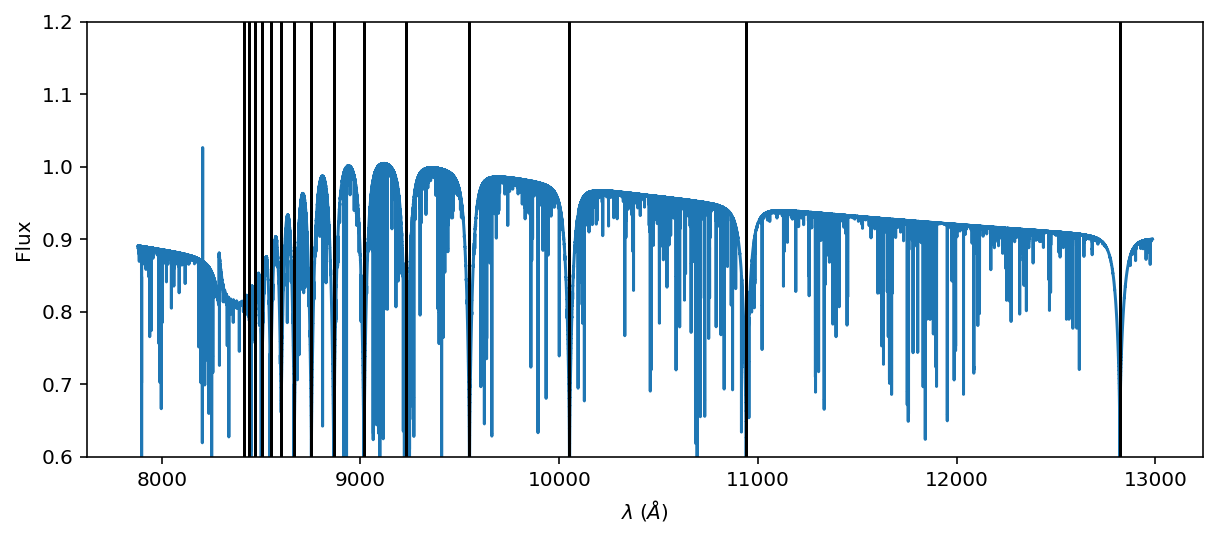

In [27]:
ax = spectrum.plot()
for line in h_lines:
    ax.axvline(line, color='k')

Nice! Let's keep that around, we'll need it later...

### Retrieve the TelFit Telluric model

Let's pick a precomputed TelFit model with comparable temperature and humidity as the data.  You can improve on your initial guess by tuning a TelFit model from scratch.  We choose to skip this laborious step here, but encourage practitioners to try it on their own.

In [28]:
data.meta['header']['ENVTEM'], data.meta['header']['ENVHUM'] # Fahrenheit and Relative Humidity

(69.722, 53.867)

That's about 290 Kelvin and 55% humidity.

Todo-- Match to a better precomputed TelFit model that matches the above values...

In [29]:
web_link = 'https://utexas.box.com/shared/static/3d43yqog5htr93qbfql3acg4v4wzhbn8.txt'

telluric_spectrum_full = TelFitSpectrum(path=web_link).air_to_vacuum()
mask = ((telluric_spectrum_full.wavelength.value > wl_lo) &
        (telluric_spectrum_full.wavelength.value < wl_hi) )
telluric_spectrum = telluric_spectrum_full.apply_boolean_mask(mask)
telluric_wl = telluric_spectrum.wavelength.value
telluric_flux = np.abs(telluric_spectrum.flux.value)
telluric_lnflux = np.log(telluric_flux) # "natural log" or log base `e`
telluric_lnflux[telluric_lnflux < -15] = -15

## Initial guess

In [30]:
system_RV = -5.0 #km/s
BERV = data.estimate_barycorr().to(u.km/u.s).value
observed_RV = system_RV - BERV#km/s
vsini = 160.0 #km/s
resolving_power = 55_000
initial_guess = spectrum.resample_to_uniform_in_velocity()\
                        .rv_shift(observed_RV)\
                        .rotationally_broaden(vsini)\
                        .instrumental_broaden(resolving_power)\
                        .resample(data)

initial_telluric = telluric_spectrum.instrumental_broaden(resolving_power)\
                                         .resample(data)

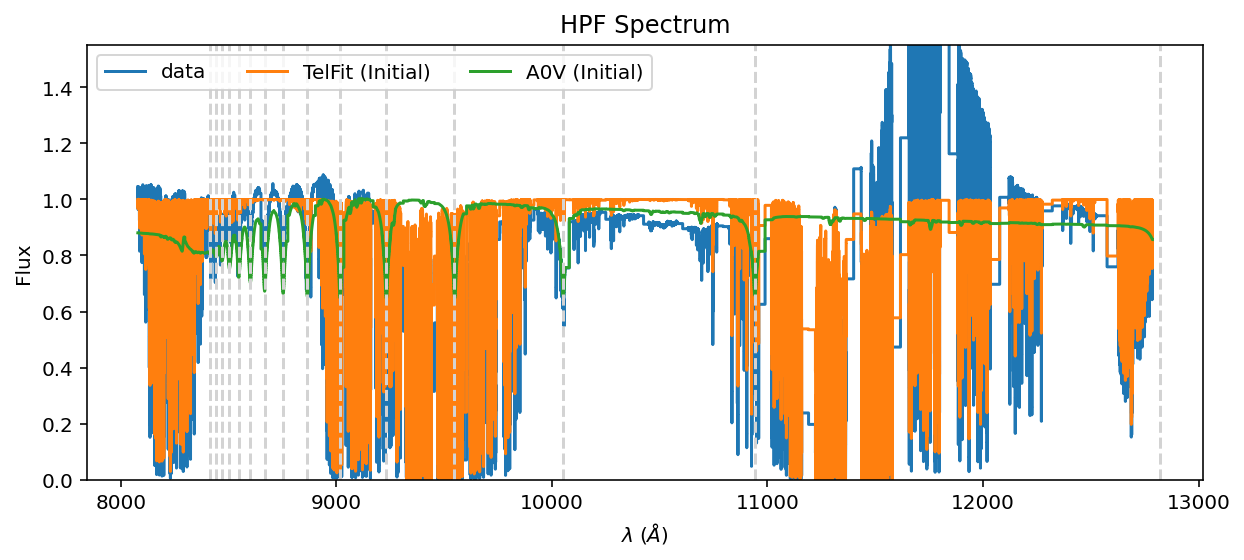

In [31]:
ax = data.plot(label='data')
initial_telluric.plot(ax=ax, label='TelFit (Initial)')
initial_guess.plot(ax=ax, label='A0V (Initial)')

for line in h_lines:
    plt.axvline(line, color='lightgray', linestyle='dashed')

#ax.set_xlim(8550,8750)
ax.legend(ncol=3);

Ok, the lines are in the right place, but the amplitudes are inexact.  Let's tune them with `blase`!

### Clone the broad Hydrogen lines

First, let's lop off the narrow lines in a low-pass filtering step.

1. Identify and mask the peaks
2. Fit a GP to the masked spectrum

In [34]:
from scipy.signal import find_peaks

In [35]:
peaks, properties = find_peaks(spectrum.flux.value, distance=10, prominence=0.01)
peak_coords = spectrum.wavelength.value[peaks]

In [36]:
wl = spectrum.wavelength.value

In [37]:
n_wl = len(wl)
n_lines = len(peak_coords)

In [44]:
1.32/8000

0.000165

In [63]:
lines_mask = np.ones(n_wl, dtype=bool)

lw = 1.9 # Angstrom
lfrac = lw/8000.0

for peak in peak_coords:
    max_coord = (peak+peak*lfrac)
    if max_coord > n_wl:
        max_coord = n_wl-1
    line_mask = (wl>(peak-peak*lfrac)) & (wl<max_coord)
    lines_mask[line_mask] = 0

In [64]:
smooth_spectrum = spectrum._copy()

In [65]:
smooth_spectrum.flux.value[~lines_mask] = np.NaN

In [66]:
clean_spectrum = spectrum.apply_boolean_mask(lines_mask)

In [67]:
smooth_spectrum.flux.shape

(361308,)

<AxesSubplot:xlabel='$\\lambda \\;(\\AA)$', ylabel='Flux'>

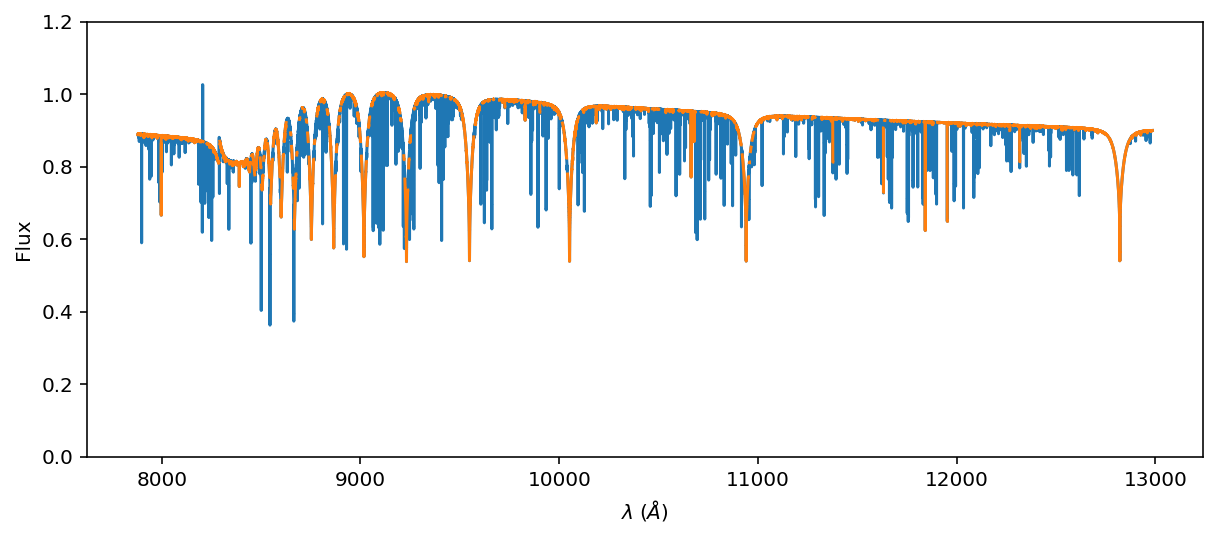

In [68]:
ax = spectrum.plot(ylo=0)
smooth_spectrum.plot(ax=ax)

Nice!  Now let's run the H-line fitting on that...

In [69]:
from collections import OrderedDict

In [70]:
lam_centers = torch.tensor(h_lines)
n_lines = len(lam_centers)
guess_amps = 30*(torch.arange(1, n_lines+1, 1)/n_lines)**2
guess_sigma = 10
guess_gamma = 0.001

In [71]:
state_dict = OrderedDict({'lam_centers':lam_centers,
                  'amplitudes':torch.log(guess_amps), 
                  'sigma_widths':torch.log(torch.repeat_interleave(torch.tensor(guess_sigma), n_lines)), 
                  'gamma_widths':torch.log(torch.repeat_interleave(torch.tensor(guess_gamma), n_lines)),
                  'a_coeff':torch.tensor(1.0), 
                  'b_coeff':torch.tensor(0.0),
                  'c_coeff':torch.tensor(0.0), 
                  'radial_velocity':torch.tensor(0.0)})

In [72]:
hydrogen_line_emulator = SparseLogEmulator(clean_spectrum.wavelength.value, 
                                           lnflux_native=np.log(clean_spectrum.flux.value),
                                           init_state_dict=state_dict, 
                                           device=device, wing_cut_pixels=90000)

/home/gully/GitHub/blase/src/blase/emulator.py:378: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.target = torch.tensor(


Initializing a sparse model with 15 spectral lines


In [73]:
hydrogen_line_emulator.to(device)

SparseLogEmulator()

In [74]:
with torch.no_grad():
    hydrogen_spectrum = hydrogen_line_emulator.forward().cpu().numpy()

We need a continuum model

Make a design matrix:

In [131]:
wl_clean = clean_spectrum.wavelength.value
y_clean = clean_spectrum.flux.value
yerr = np.repeat(0.001, len(wl_clean))

In [128]:
from scipy.special import voigt_profile
import celerite2
from celerite2 import terms

In [129]:
# Non-periodic component
term2 = terms.SHOTerm(sigma=0.04, rho=1500.0, Q=0.25)
kernel = term2

# Setup the GP
gp = celerite2.GaussianProcess(kernel, mean=0.0)
gp.compute(wl_clean, yerr=None)

In [141]:
@np.vectorize
def hydrogen_linear_model_gof(guess_sigma, guess_gamma, npoly = 6):
    A_hlines = [voigt_profile(wl_clean-h_line, guess_sigma, guess_gamma) for h_line in h_lines ]
    A_hlines = np.vstack(A_hlines).T
    A_poly = np.vander(wl_clean, N=npoly)
    A = np.hstack((A_poly, A_hlines))
    ATA = np.dot(A.T, A)
    sigma_w = np.linalg.inv(ATA)
    mean_w = np.linalg.solve(ATA, np.dot(A.T, y_clean))
    yfit = np.dot(A, mean_w)
    #ycont = np.dot(A[:, :npoly], mean_w[:npoly])
    resid = clean_spectrum.flux.value - yfit
    return np.sum(resid**2)

In [142]:
#ax = clean_spectrum.plot(label='A0V (Initial)')
#ax.plot(clean_spectrum.wavelength, ycont)
#ax.plot(clean_spectrum.wavelength, yfit)
#plt.ylim(0, 1.1)

In [160]:
sigma_grid = np.arange(1, 20, 1)

In [161]:
n_steps = len(sigma_grid)

In [162]:
gof_matrix = np.zeros((n_steps, n_steps))

In [163]:
for i in range(n_steps):
    print(i, end=' ')
    gofs = hydrogen_linear_model_gof(sigma_grid, sigma_grid[i])
    gof_matrix[:, i] = gofs

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 

In [ ]:
import

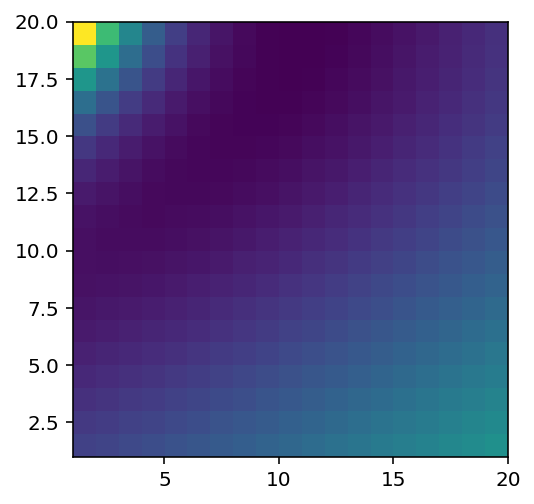

In [164]:
cb = plt.imshow(gof_matrix, extent=[1,20, 1, 20])


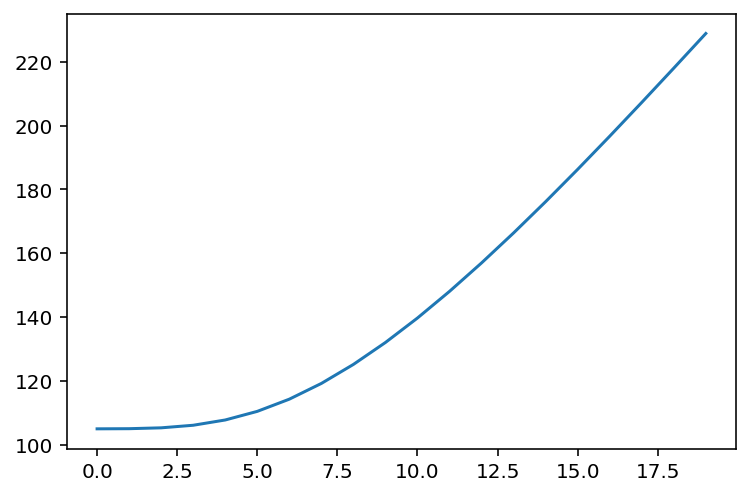

In [155]:
plt.plot(sigma_grid, gofs)

(-0.5, 0.5)

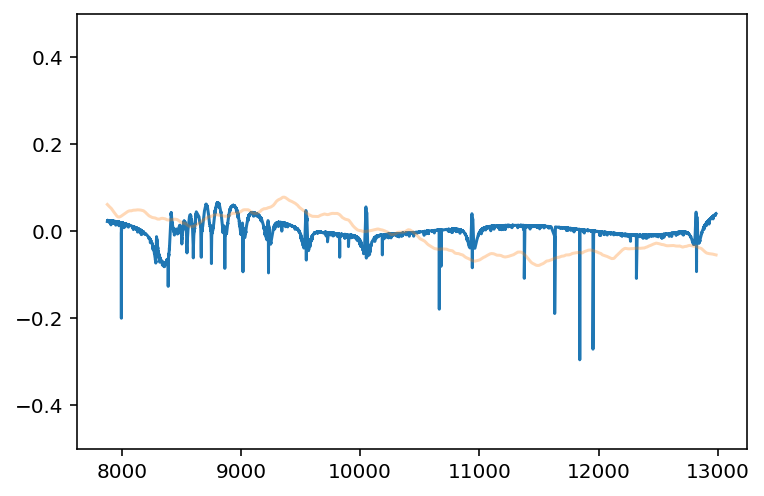

In [126]:
plt.plot(wl_clean, clean_spectrum.flux.value - yfit)
plt.plot(wl_clean, gp.sample(), alpha=0.3)
plt.ylim(-0.5, 0.5)

In [127]:
print("Initial log likelihood: {0}".format(gp.log_likelihood(resid)))

Initial log likelihood: -1493250831562.8562


In [120]:
hydrogen_line_emulator.amplitudes.requires_grad = True
hydrogen_line_emulator.radial_velocity.requires_grad = True
hydrogen_line_emulator.amplitudes.requires_grad = True
hydrogen_line_emulator.a_coeff.requires_grad = True
hydrogen_line_emulator.b_coeff.requires_grad = True
hydrogen_line_emulator.c_coeff.requires_grad = True

In [121]:
hydrogen_line_emulator.optimize(epochs=1000, LR=0.01)

Training Loss: 0.00402266:  22%|██▊          | 218/1000 [00:17<01:01, 12.81it/s]


KeyboardInterrupt: 

In [122]:
with torch.no_grad():
    hydrogen_spectrum = hydrogen_line_emulator.forward().cpu().numpy()

In [123]:
hydrogen_line_emulator.sigma_widths

Parameter containing:
tensor([2.6714, 3.4736, 4.8834, 4.9980, 4.8380, 5.5193, 3.6410, 2.9644, 3.2258,
        3.6747, 4.5191], device='cuda:0', requires_grad=True)

In [124]:
hydrogen_line_emulator.amplitudes

Parameter containing:
tensor([0.8325, 1.8619, 3.0198, 3.5634, 3.5746, 3.5354, 3.1994, 3.0520, 3.4540,
        3.8882, 5.0651], device='cuda:0', requires_grad=True)

In [125]:
hydrogen_line_emulator.gamma_widths

Parameter containing:
tensor([-6.9079, -6.9078, -6.9071, -6.9067, -6.9073, -6.9078, -6.9078, -6.9090,
        -6.9063, -6.9086, -6.9025], device='cuda:0', requires_grad=True)

In [126]:
def laplace_func(x, amp, mu, bscale):
    return amp*torch.exp(-torch.abs(x-mu)/bscale)

In [127]:
#laplace_line = 1-laplace_func(torch.tensor(spectrum.wavelength.value), 0.5, h_lines[-1]*1.0005, 20)

(0.0, 1.1)

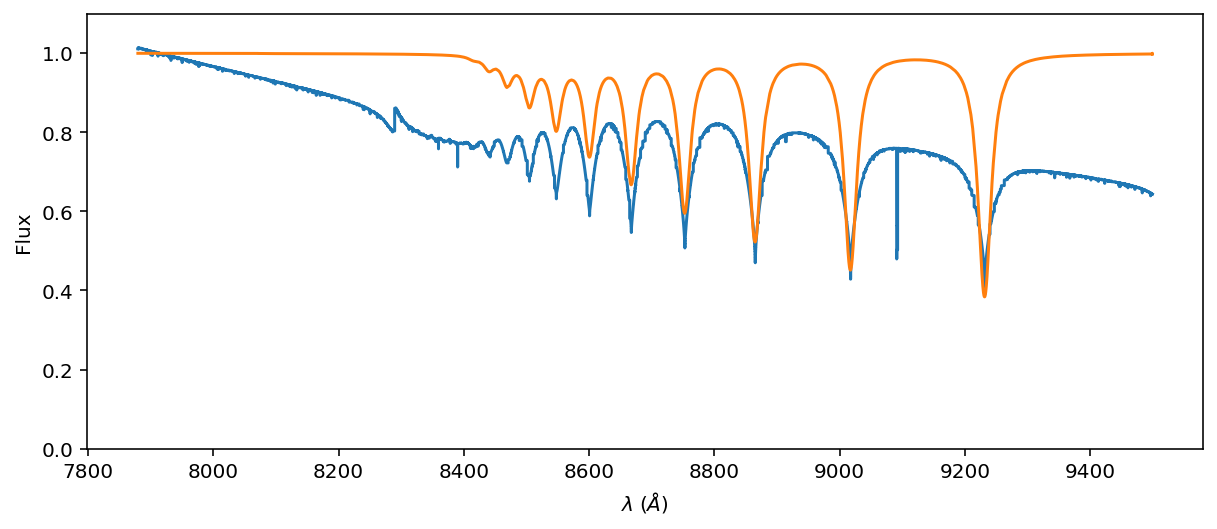

In [48]:
ax = clean_spectrum.plot(label='A0V (Initial)')
ax.plot(wl_clean, hydrogen_spectrum)
#ax.plot(hydrogen_line_emulator.wl_native, laplace_line)
plt.ylim(0, 1.1)

### Clone the stellar and telluric model

In [19]:
stellar_emulator = SparseLogEmulator(spectrum.wavelength.value, 
                                     np.log(spectrum.flux.value), prominence=0.02, 
                                     device=device, wing_cut_pixels=1000)
stellar_emulator.to(device)

/home/gully/GitHub/blase/src/blase/emulator.py:378: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.target = torch.tensor(


Initializing a sparse model with 157 spectral lines


SparseLogEmulator()

In [20]:
telluric_emulator = SparseLogEmulator(telluric_spectrum.wavelength.value, 
                                      telluric_lnflux, 
                                      prominence=0.02, device=device, wing_cut_pixels=800)
telluric_emulator.to(device)

Initializing a sparse model with 871 spectral lines


SparseLogEmulator()

### Fine-tune the clone

In [21]:
with torch.no_grad():
    telluric_clone = telluric_emulator.forward().cpu().numpy()

In [22]:
with torch.no_grad():
    star_clone = stellar_emulator.forward().cpu().numpy()

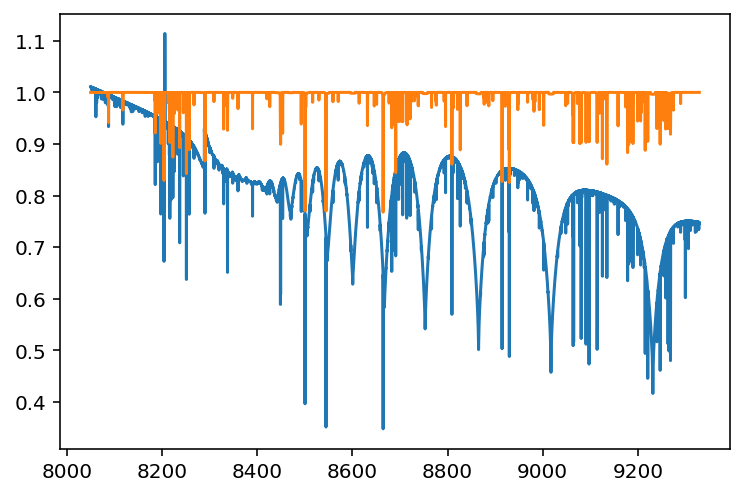

In [24]:
plt.plot(stellar_emulator.wl_native.cpu(), spectrum.flux.value)
plt.plot(stellar_emulator.wl_native.cpu(), star_clone)

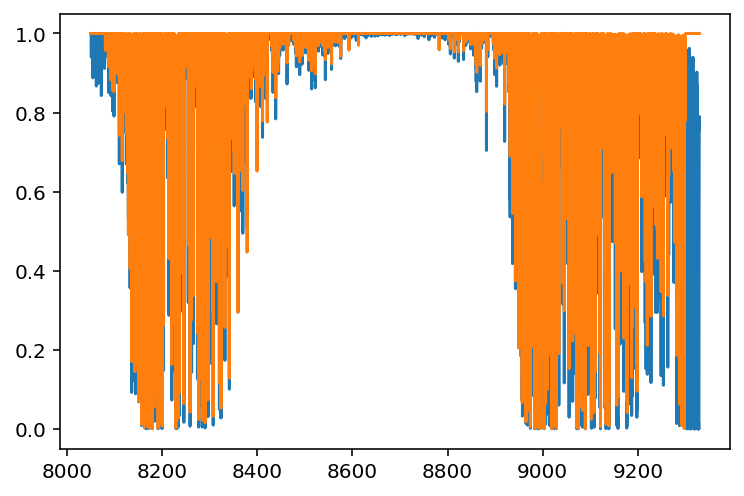

In [22]:
plt.plot(telluric_emulator.wl_native.cpu(), telluric_spectrum.flux.value)
plt.plot(telluric_emulator.wl_native.cpu(), telluric_clone)

In [23]:
stellar_emulator.optimize(epochs=100, LR=0.01)

Training Loss: 0.04174669: 100%|██████| 100/100 [00:01<00:00, 71.00it/s]


In [24]:
telluric_emulator.optimize(epochs=100, LR=0.01)

Training Loss: 0.00009790: 100%|██████| 100/100 [00:04<00:00, 21.37it/s]


### Step 3: Extrinsic model

In [25]:
extrinsic_layer = ExtrinsicModel(wavelength_grid, device=device)
vsini = torch.tensor(vsini)
extrinsic_layer.ln_vsini.data = torch.log(vsini)
extrinsic_layer.to(device)

ExtrinsicModel()

(Remap the stellar and telluric emulator to a standardized wavelength grid).

In [26]:
stellar_emulator = SparseLogEmulator(wavelength_grid, 
                                     init_state_dict=stellar_emulator.state_dict(), device=device)
stellar_emulator.radial_velocity.data = torch.tensor(observed_RV)
stellar_emulator.to(device)
telluric_emulator = SparseLogEmulator(wavelength_grid, 
                                     init_state_dict=telluric_emulator.state_dict(), device=device)
telluric_emulator.to(device)

Initializing a sparse model with 157 spectral lines
Initializing a sparse model with 871 spectral lines


SparseLogEmulator()

#### Forward model

In [27]:
stellar_flux = stellar_emulator.forward()
broadened_flux = extrinsic_layer(stellar_flux)
telluric_attenuation = telluric_emulator.forward()

#### Joint telluric and stellar model

In [28]:
flux_at_telescope = broadened_flux * telluric_attenuation

#### Instrumental model

In [29]:
instrumental_model = InstrumentalModel(data.bin_edges.value, wavelength_grid, device=device)
instrumental_model.to(device)

InstrumentalModel(
  (linear_model): Linear(in_features=15, out_features=1, bias=True)
)

In [30]:
instrumental_model.ln_sigma_angs.data = torch.log(torch.tensor(0.064))

In [31]:
detector_flux = instrumental_model.forward(flux_at_telescope)

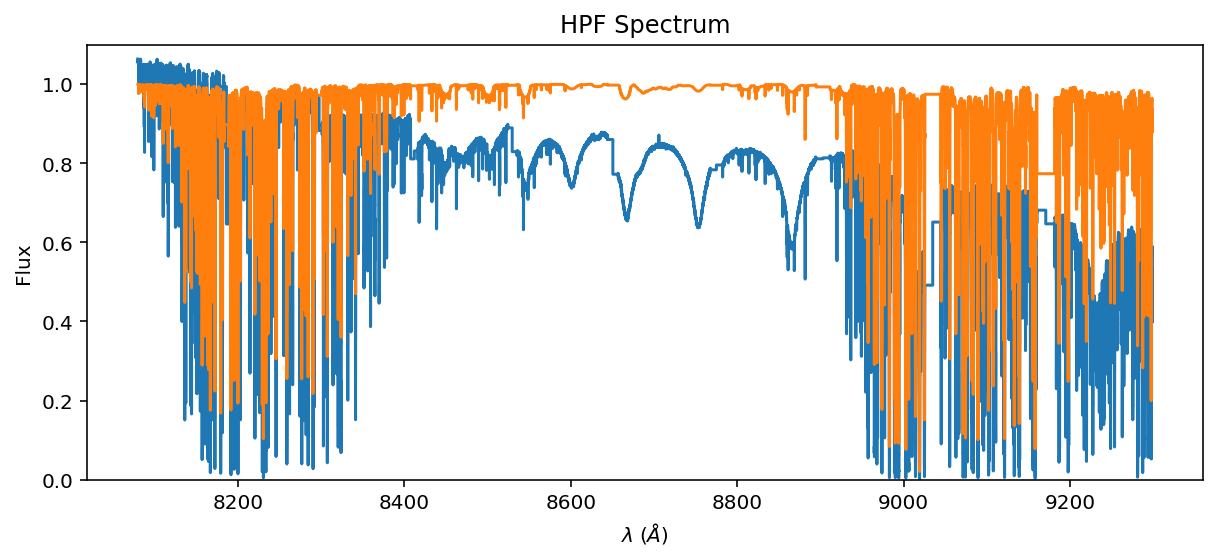

In [32]:
ax = data.plot(yhi=1.1)
ax.step(data.wavelength, detector_flux.detach().cpu().numpy());
#ax.set_xlim(8320, 8340)

## Transfer learn a semi-empirical model

Here we compare the resampled joint model to the observed data to "transfer learn" underlying super resolution spectra.

In [27]:
from torch import nn
from tqdm import trange
import torch.optim as optim

In [28]:
data_target = torch.tensor(
    data.flux.value.astype(np.float64), device=device, dtype=torch.float64
)

data_wavelength = torch.tensor(
    data.wavelength.value.astype(np.float64), device=device, dtype=torch.float64
)

In [29]:
loss_fn = nn.MSELoss(reduction="mean")

### Fix certain parameters, allow others to vary
As we have seen before, you can fix parameters by "turning off their gradients".  We will start by turning off *ALL* gradients.  Then turn on some.

In [47]:
stellar_emulator.amplitudes.requires_grad = True
stellar_emulator.radial_velocity.requires_grad = True
telluric_emulator.amplitudes.requires_grad = True
instrumental_model.ln_sigma_angs.requires_grad = True

In [48]:
optimizer = optim.Adam(
    list(filter(lambda p: p.requires_grad, stellar_emulator.parameters()))
    + list(filter(lambda p: p.requires_grad, telluric_emulator.parameters()))
    + list(filter(lambda p: p.requires_grad, extrinsic_layer.parameters()))
    + list(filter(lambda p: p.requires_grad, instrumental_model.parameters())),
    0.01,
    amsgrad=True,
)         

In [54]:
n_epochs = 2000
losses = []

## Regularization is fundamental

The blase model as it stands is **too flexible**.  It must have regularization to balance its propensity to overfit.

First, we need to assign uncertainty to the data in order to weigh the prior against new data:

In [55]:
# We need uncertainty to be able to compute the posterior
# Assert fixed per-pixel uncertainty for now
per_pixel_uncertainty = torch.tensor(0.01, device=device, dtype=torch.float64)

Then we need the prior.  For now, let's just apply priors on the amplitudes (almost everything else is fixed).  We need to set the regularization hyperparameter tuning.

In [56]:
stellar_amp_regularization = 5.1
telluric_amp_regularization = 5.1

In [57]:
import copy

In [58]:
with torch.no_grad():
    stellar_init_amps = copy.deepcopy(stellar_emulator.amplitudes)
    telluric_init_amps = copy.deepcopy(telluric_emulator.amplitudes)

# Define the prior on the amplitude
def ln_prior(stellar_amps, telluric_amps,):
    """
    Prior for the amplitude vector
    """
    amp_diff1 = stellar_init_amps - stellar_amps
    ln_prior1 = 0.5 * torch.sum((amp_diff1 ** 2) / (stellar_amp_regularization ** 2))
    
    amp_diff2 = telluric_init_amps - telluric_amps
    ln_prior2 = 0.5 * torch.sum((amp_diff2 ** 2) / (telluric_amp_regularization ** 2))

    return ln_prior1 + ln_prior2

In [59]:
t_iter = trange(n_epochs, desc="Training", leave=True)
for epoch in t_iter:
    stellar_emulator.train()
    telluric_emulator.train()
    extrinsic_layer.train()
    instrumental_model.train()
    
    stellar_flux = stellar_emulator.forward()
    broadened_flux = extrinsic_layer(stellar_flux)
    telluric_attenuation = telluric_emulator.forward()
    flux_at_telescope = broadened_flux * telluric_attenuation
    detector_flux = instrumental_model.forward(flux_at_telescope)
    
    loss = loss_fn(detector_flux / per_pixel_uncertainty, data_target / per_pixel_uncertainty)
    loss += ln_prior(stellar_emulator.amplitudes, telluric_emulator.amplitudes)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    t_iter.set_description("Training Loss: {:0.8f}".format(loss.item()))

Training Loss: 8.60397831: 100%|███████████████████████████| 2000/2000 [02:43<00:00, 12.24it/s]


### Spot check the transfer-learned joint model

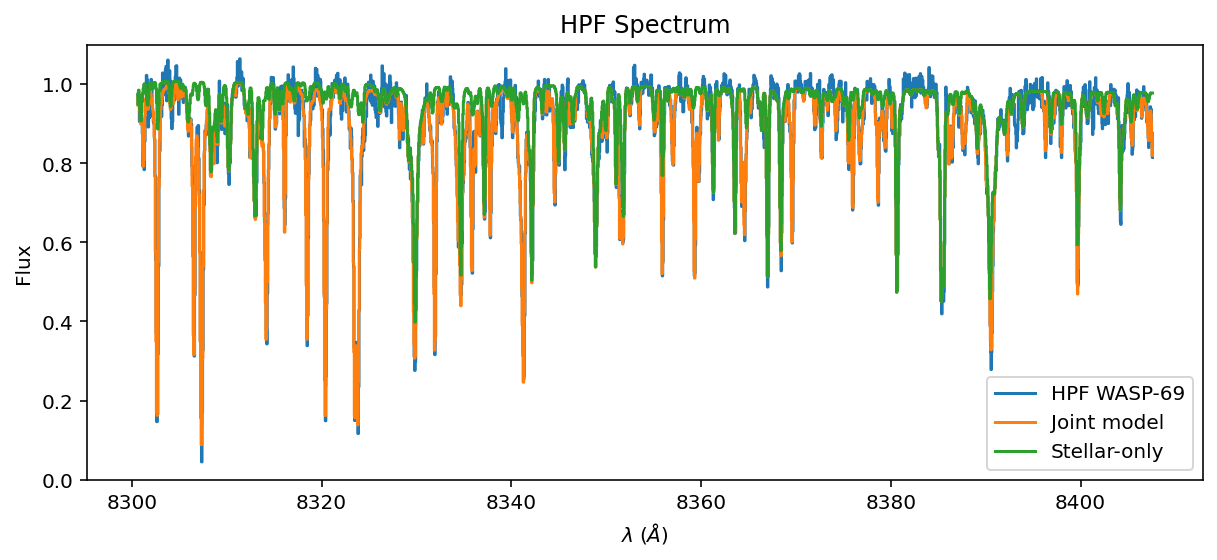

In [60]:
ax = data.plot(yhi=1.1, label='HPF WASP-69')
ax.step(data.wavelength, detector_flux.detach().cpu().numpy(), label='Joint model');
ax.step(data.wavelength, instrumental_model.forward(broadened_flux).detach().cpu().numpy(),
       label='Stellar-only');
ax.legend()

(8320.0, 8340.0)

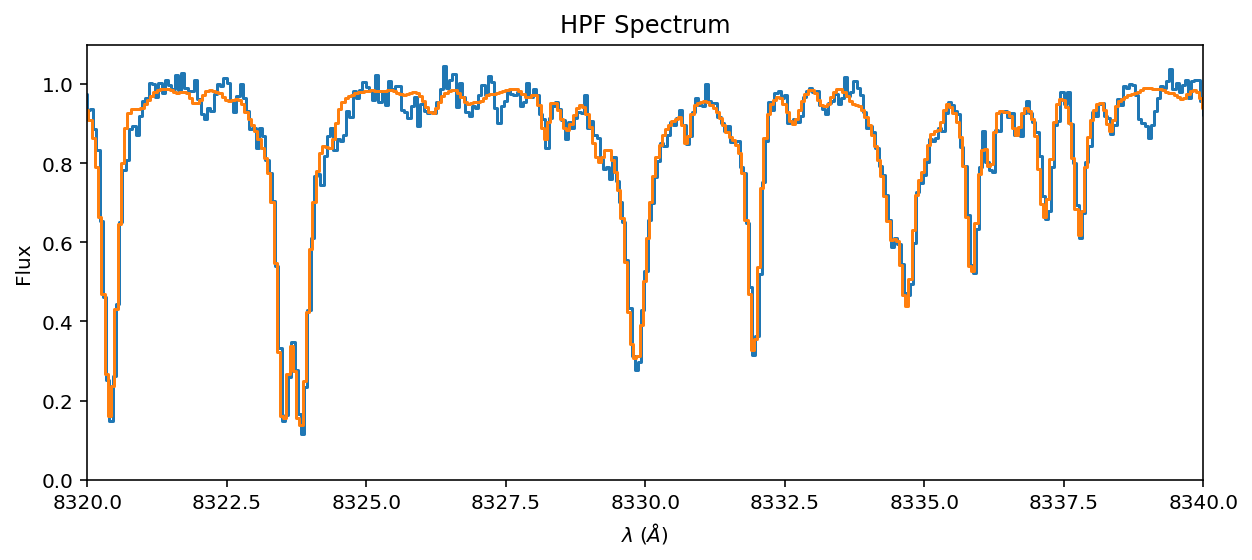

In [61]:
ax = data.plot(yhi=1.1)
ax.step(data.wavelength, detector_flux.detach().cpu().numpy());
ax.set_xlim(8320, 8340)

Don't get too excited! This performance is **very overfit**.  It needs regularization!

### Inspect the individual stellar and telluric components

In [62]:
with torch.no_grad():
    stellar_emulator.radial_velocity.data *=0
    stellar_post = stellar_emulator.forward().cpu().numpy()
    telluric_post = telluric_emulator.forward().cpu().numpy()

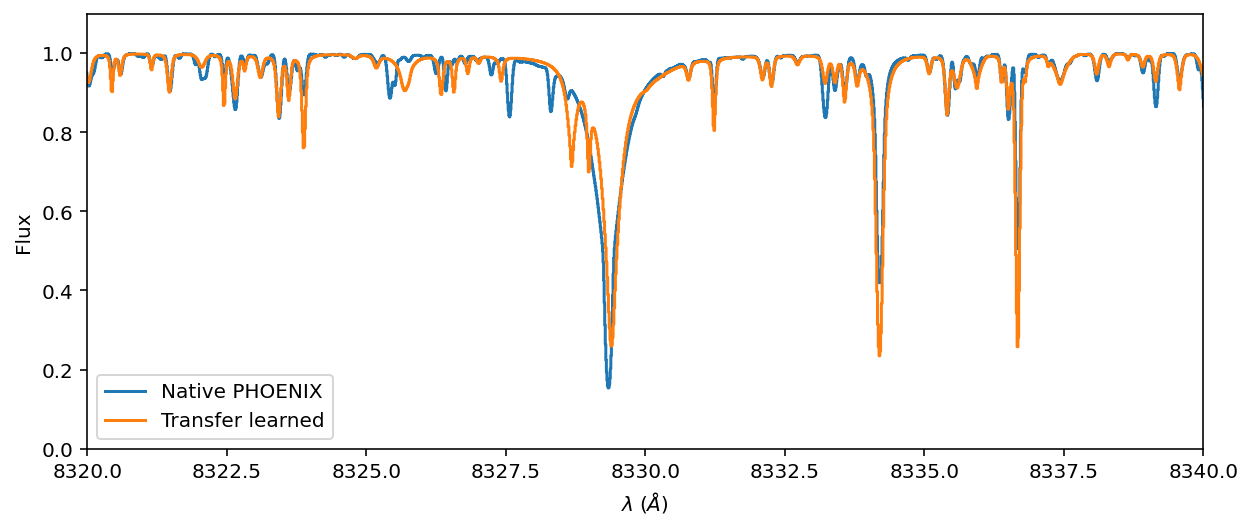

In [63]:
ax = spectrum.plot(ylo=0, yhi=1.1, label='Native PHOENIX')
ax.step(wavelength_grid, stellar_post, label='Transfer learned');
ax.legend()
ax.set_xlim(8320, 8340);

You can see that the telluric and stellar models compensated for imperfections in the line wings by overbloating the amplitudes of bystander lines.  This unlikely tradeoff makes sense once the line is convolved with an instrument kernel.

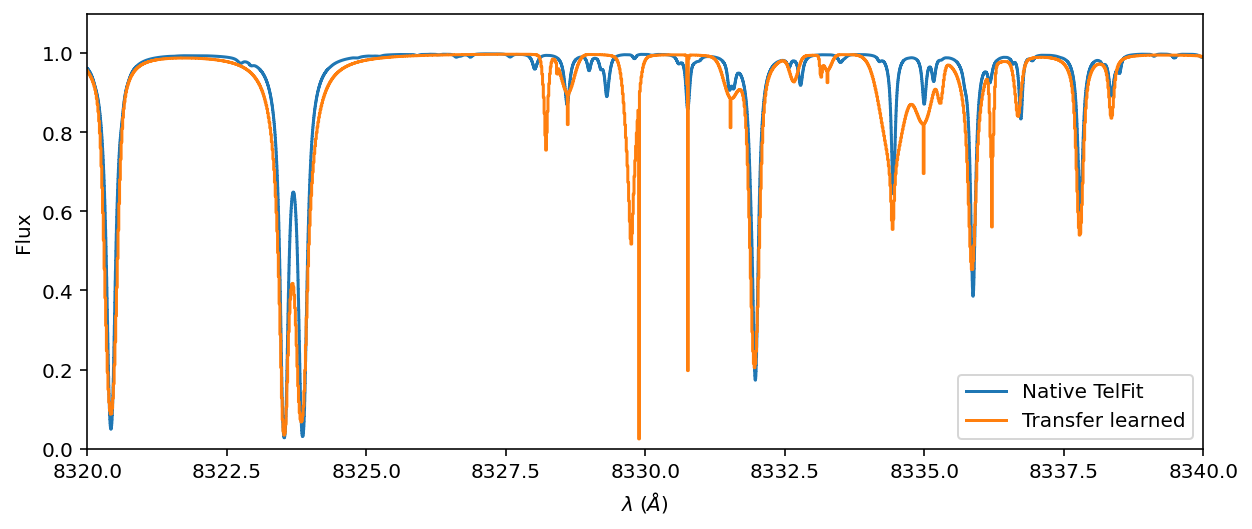

In [64]:
ax = telluric_spectrum.plot(ylo=0, yhi=1.1, label='Native TelFit')
ax.step(wavelength_grid, telluric_post, label='Transfer learned');
ax.legend()
ax.set_xlim(8320, 8340);

Voilá! We did it! We tuned the telluric and stellar line amplitudes simultaneously with real high resolution data.  We notice a few remaining inperfections.  Here are the next steps to fix those imperfections:

1. **Overall fit quality and hyperparameter tuning**   
First, the fit quality isn't great.  We probably want to tune the regularization to learn from the data a bit more than the model.  This tuning is the trickiest hyperparameter to get right in blasé.

2. **Expand regularization to include all other parameters**  
We are only tuning amplitudes right now (and RV and instrumental resolution).  Let's tune and regularize all of the parameters (in a judicious way).

3. **More flexible super-Lorentzian shapes**  
The broad and deep stellar lines depart significantly from their expectations in the PHOENIX models.  In those cases, we want to allow the line widths to adapt.  But *even if* we allowed the linewings to float, the updates will likely fall short of reality.  We should make the line widths more flexible, as described in the paper.

4. **Start with a better template**   
Ideally you want to start with the best possible template, the precomputed synthetic spectral model that most closely resembles your spectrum *a-priori*.  We should especially strive for this goal with TelFit, which offers fine-tuning.  In particular, we should adapt the Earth's $P-T$ profile to match reality, instead of the static template we default to.  We may also be slightly wrong in terms of the number of layers of the atmosphere, and how it rounds the dense final layer closest to the Observatory.

5. **Train for longer**   
Simply training for longer than mitigate some poor initialization artifacts.  You have to be a bit careful, since early-stopping can act as a form of regularization too.